In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('/Users/Kim/SMU/MS7349/data.csv', index_col='shot_id')

In [5]:
# Keep the year with the extension to simplified analysis
df['season'] = df['season'].apply(lambda x: x[:4])
df['season'] = pd.to_numeric(df['season'])

In [9]:
# Count of Missing Data
df.isnull().sum()

action_type              0
combined_shot_type       0
game_event_id            0
game_id                  0
lat                      0
loc_x                    0
loc_y                    0
lon                      0
minutes_remaining        0
period                   0
playoffs                 0
season                   0
seconds_remaining        0
shot_distance            0
shot_made_flag        5000
shot_type                0
shot_zone_area           0
shot_zone_basic          0
shot_zone_range          0
team_id                  0
team_name                0
game_date                0
matchup                  0
opponent                 0
dtype: int64

In [5]:
# Print columns with null values
df.columns[df.isnull().any()]

Index(['shot_made_flag'], dtype='object')

In [73]:
# Create new dataframe with null shot_made_flag removed
df2 = df[df['shot_made_flag'].notnull()].reset_index()
df2.shape

(25697, 25)

In [8]:
# Create summary statistics
summary = df2.describe()

# Print the summary
print(summary)


            shot_id  game_event_id       game_id           lat         loc_x  \
count  25697.000000   25697.000000  2.569700e+04  25697.000000  25697.000000   
mean   15328.166946     249.348679  2.474109e+07     33.953043      7.148422   
std     8860.462397     149.778520  7.738108e+06      0.088152    110.073147   
min        2.000000       2.000000  2.000001e+07     33.253300   -250.000000   
25%     7646.000000     111.000000  2.050006e+07     33.884300    -67.000000   
50%    15336.000000     253.000000  2.090034e+07     33.970300      0.000000   
75%    22976.000000     367.000000  2.960027e+07     34.040300     94.000000   
max    30697.000000     653.000000  4.990009e+07     34.088300    248.000000   

              loc_y           lon  minutes_remaining        period  \
count  25697.000000  25697.000000       25697.000000  25697.000000   
mean      91.257345   -118.262652           4.886796      2.520800   
std       88.152106      0.110073           3.452475      1.151626   

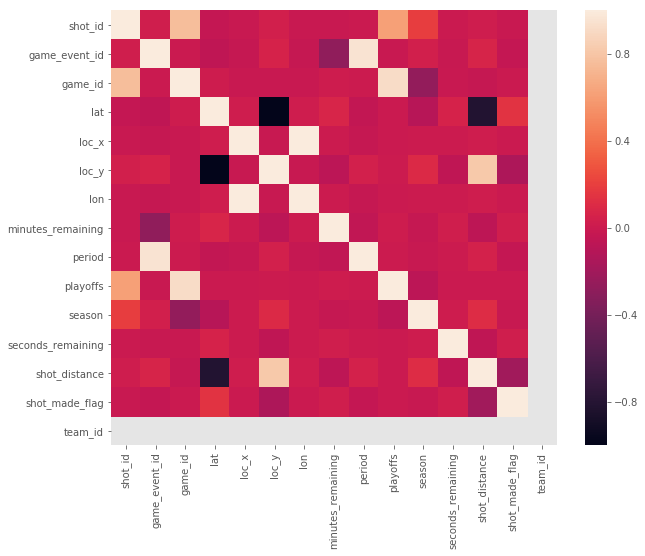

In [22]:
# Check multicolinarity and correlationship
f, ax = plt.subplots(figsize=(10, 8))
corr3 = df2.corr()
sns.heatmap(corr3,ax=ax)

In [28]:
# Categorical variables were transformed as dummies labels and combine with existing numerical labels
# This analysis is mainly focusing on type of shot_style that Kobe Byrant frequently performed during his 20 years
# career and its relationship with distance and seasonality
#redundant columns such as Team_ID, game_event_id, game_ID are dropped for clarity
cols_d = df2[['action_type','combined_shot_type','shot_type','shot_zone_area']]
dummies_cl = pd.get_dummies(cols_d)

#Drop existing categotical labels to incorporate dummies and remaining numeric labels
df2_cl = df2.drop(['action_type','combined_shot_type','shot_type','shot_zone_area','game_event_id','game_id','team_id','loc_x','loc_y','team_name'],axis=1)
df_dummie_cl = df2_cl.join(dummies_cl)
df_dummie_cl.head(5)


,shot_id,lat,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,...,combined_shot_type_Layup,combined_shot_type_Tip Shot,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R)
0,2,34.0443,-118.4268,10,1,0,2000,22,15,0.0,...,0,0,1,0,0,0,0,1,0,0
1,3,33.9093,-118.3708,7,1,0,2000,45,16,1.0,...,0,0,1,0,0,0,1,0,0,0
2,4,33.8693,-118.1318,6,1,0,2000,52,22,0.0,...,0,0,1,0,0,0,0,0,1,0
3,5,34.0443,-118.2698,6,2,0,2000,19,0,1.0,...,0,0,1,0,0,1,0,0,0,0
4,6,34.0553,-118.4148,9,3,0,2000,32,14,0.0,...,0,0,1,0,0,0,0,1,0,0


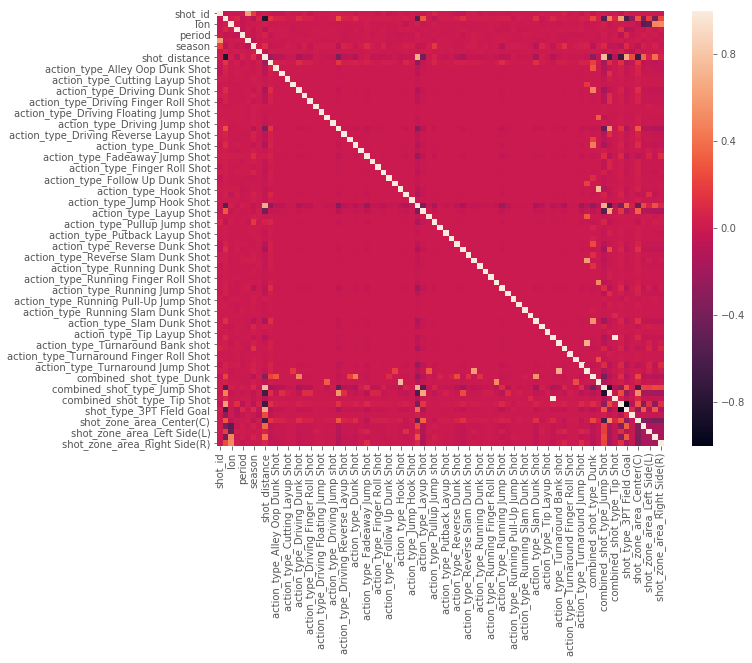

In [12]:
# Heat Map indicates correlation of all variables
f, ax = plt.subplots(figsize=(10, 8))
corr_cl_dum = df_dummie_cl.corr()
sns.heatmap(corr_cl_dum,ax=ax)

In [27]:
# Table below indicates Shot_made correlated with distance (lat); shot_distance; 
# combined shot_type of Dunk, Layup and Jump Shot and shot_zone_center. That said, it is weak
corr_cl_dum

,shot_id,lat,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,...,combined_shot_type_Layup,combined_shot_type_Tip Shot,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R)
shot_id,1.000000,-0.033476,-0.012453,-0.008251,-0.003357,0.612991,0.192712,-0.004833,0.020464,-0.013016,...,-0.014853,0.003524,-0.043572,0.043572,-0.002393,0.005326,0.006340,0.002342,-0.001138,-0.014023
lat,-0.033476,1.000000,0.017578,0.077399,-0.039737,-0.000857,-0.096691,0.057766,-0.818124,0.148070,...,0.463097,0.078527,0.606221,-0.606221,-0.273666,0.287579,-0.378327,0.192215,-0.413187,0.240648
lon,-0.012453,0.017578,1.000000,0.006624,-0.030059,-0.007751,0.005457,0.001512,0.022307,-0.000848,...,-0.028201,-0.004987,0.006003,-0.006003,-0.003489,-0.048268,-0.517625,-0.499177,0.493303,0.513799
minutes_remaining,-0.008251,0.077399,0.006624,1.000000,-0.047021,0.009583,-0.024212,0.024232,-0.064159,0.028342,...,-0.000324,-0.007172,0.119656,-0.119656,-0.074604,-0.006746,-0.020357,0.028617,-0.009948,0.023502
period,-0.003357,-0.039737,-0.030059,-0.047021,1.000000,0.003905,-0.020712,0.007153,0.047311,-0.032152,...,-0.018466,0.005658,-0.082083,0.082083,-0.023972,-0.007783,0.024047,0.007112,0.008283,-0.023248
playoffs,0.612991,-0.000857,-0.007751,0.009583,0.003905,1.000000,-0.077761,-0.005951,-0.007751,-0.001257,...,-0.000223,0.005416,0.013631,-0.013631,0.007231,0.013773,-0.010435,0.007059,-0.014364,-0.002266
season,0.192712,-0.096691,0.005457,-0.024212,-0.020712,-0.077761,1.000000,0.008350,0.111624,-0.018777,...,-0.058092,-0.047837,-0.095649,0.095649,-0.015027,-0.065900,0.044702,-0.000359,0.054355,-0.003155
seconds_remaining,-0.004833,0.057766,0.001512,0.024232,0.007153,-0.005951,0.008350,1.000000,-0.055875,0.030804,...,0.012248,-0.000387,0.046934,-0.046934,-0.084844,0.011329,-0.009606,0.006382,-0.007533,0.007669
shot_distance,0.020464,-0.818124,0.022307,-0.064159,0.047311,-0.007751,0.111624,-0.055875,1.000000,-0.198242,...,-0.642659,-0.108728,-0.668282,0.668282,0.236587,-0.652775,0.372199,0.060009,0.392356,0.068097
shot_made_flag,-0.013016,0.148070,-0.000848,0.028342,-0.032152,-0.001257,-0.018777,0.030804,-0.198242,1.000000,...,0.110712,-0.015126,0.121462,-0.121462,-0.046095,0.141378,-0.066352,-0.036942,-0.054775,-0.037634


In [16]:
# Total field goal collected over Kobe's career is 30,697 attempted shots. 
# With 5,000 held for testing set, the analysis is on remaining 25,697 shots. 
# Of the given data, Kobe made 44.616% of the shots, 11,465 shots

print(df2['shot_made_flag'].value_counts() / df2['shot_made_flag'].shape)
print(df2['shot_made_flag'].value_counts() )

0.0    0.553839
1.0    0.446161
Name: shot_made_flag, dtype: float64
0.0    14232
1.0    11465
Name: shot_made_flag, dtype: int64


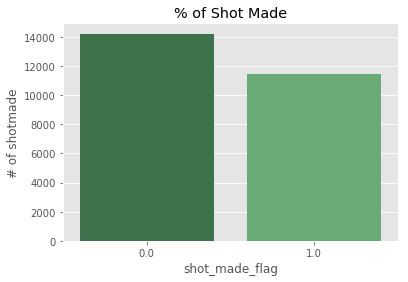

In [13]:
# Shot success rate is about 44.6% of the time
sns.countplot(x='shot_made_flag', data=df2, palette="Greens_d");
plt.ylabel('# of shotmade')
plt.title('% of Shot Made')
plt.show()


In [15]:
# Descriptive statistics on categorical labels. 
# Jump Shot, the most performed 2 point field goal shot style, is mostly performed in Center which is 16-24ft 
# from the hoop

df2.describe(include=['object'])

,action_type,combined_shot_type,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,25697,25697,25697,25697,25697,25697,25697,25697,25697,25697
unique,55,6,2,6,7,5,1,1558,74,33
top,Jump Shot,Jump Shot,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,15836,19710,20285,11289,10532,7857,25697,43,853,1638


In [34]:
# Of all the shot_style success rate, Dunk is 92% follow with Bank Shot and Layup
df2[['combined_shot_type', 'shot_made_flag']].groupby(['combined_shot_type']).mean().sort_values(by='shot_made_flag', ascending=False)

,shot_made_flag
combined_shot_type,
Dunk,0.928030
Bank Shot,0.791667
Layup,0.565093
Hook Shot,0.535433
Jump Shot,0.391071
Tip Shot,0.348684


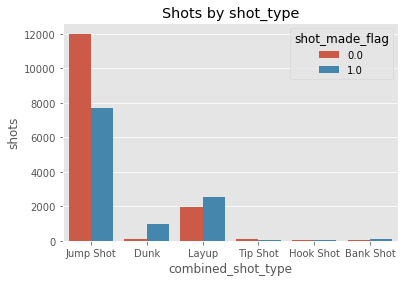

In [31]:
# Majority of Kobe’s shots are jump shots, with layups and dunks coming in next
# Jump Short is the most preformed shot type but has the lowest shot_completion mean indicated in hbar
sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=df2)
plt.ylabel('shots')
plt.title('Shots by shot_type')
plt.show()

In [36]:
# summary about the distribution of shot_made within the group
df_bygroup = df2.groupby( ['combined_shot_type'])
print(df_bygroup['shot_made_flag'].agg([len, np.sum, np.mean, np.std])) #len = count
print ('---------------------------------------')
print(df_bygroup['shot_made_flag'].value_counts() / df2['shot_made_flag'].shape)

                        len     sum      mean       std
combined_shot_type                                     
Bank Shot             120.0    95.0  0.791667  0.407819
Dunk                 1056.0   980.0  0.928030  0.258560
Hook Shot             127.0    68.0  0.535433  0.500718
Jump Shot           19710.0  7708.0  0.391071  0.488003
Layup                4532.0  2561.0  0.565093  0.495800
Tip Shot              152.0    53.0  0.348684  0.478129
---------------------------------------
combined_shot_type  shot_made_flag
Bank Shot           1.0               0.003697
                    0.0               0.000973
Dunk                1.0               0.038137
                    0.0               0.002958
Hook Shot           1.0               0.002646
                    0.0               0.002296
Jump Shot           0.0               0.467058
                    1.0               0.299957
Layup               1.0               0.099661
                    0.0               0.076702
Tip Sho

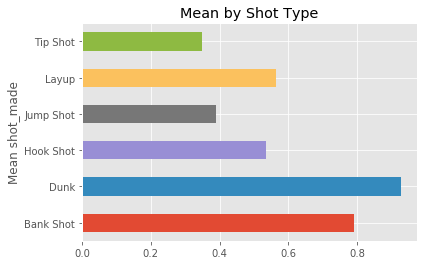

In [35]:
# Accuracy by shot_type 
# Dunk has the highest shot_completion of all styles with mean of 92.8%

st = df2['shot_made_flag'].groupby(df2['combined_shot_type']).mean()
st.plot(kind='barh', figsize=(6, 4))
plt.ylabel('Mean shot_made')
plt.title('Mean by Shot Type')

shot_made_flag          0     1
combined_shot_type             
Bank Shot              25    95
Dunk                   76   980
Hook Shot              59    68
Jump Shot           12002  7708
Layup                1971  2561
Tip Shot               99    53
---------------------------------------
shot_made_flag         0         1
shot_type                         
2PT Field Goal  0.522652  0.477348
3PT Field Goal  0.670732  0.329268
---------------------------------------
shot_made_flag                            0         1
shot_type      combined_shot_type                    
2PT Field Goal Bank Shot           0.001686  0.008286
               Dunk                0.005340  0.085478
               Hook Shot           0.004146  0.005931
               Jump Shot           0.588322  0.516877
               Layup               0.138491  0.223375
               Tip Shot            0.006956  0.004623
3PT Field Goal Bank Shot           0.000070  0.000000
               Jump Shot           0.2

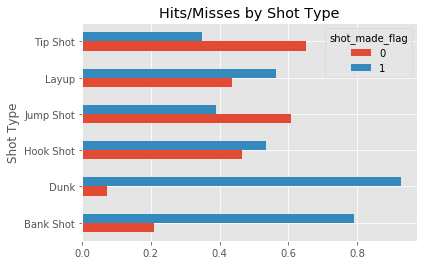

In [38]:
# Most performed combined_shot_style is Jump Shot - 76.7% (7,708 out of 12,002)
# Kobe has higher shot success in 2-point field goal, 47.7% of the time
# Of the shot_style in 2-point field goal, jump shot has the highest shot success at 51.7% 
# 

st_count = pd.crosstab([ df2['combined_shot_type'] ], 
                     df2.shot_made_flag.astype(int))
st_count2 = pd.crosstab([ df2['shot_type']], 
                   df2.shot_made_flag.astype(int), normalize='index')
st_count3 = pd.crosstab([ df2['shot_type'],df2['combined_shot_type'] ], 
                   df2.shot_made_flag.astype(int), normalize='columns')
print (st_count)
print ('---------------------------------------')

print (st_count2)
print ('---------------------------------------')

print (st_count3)
print ('---------------------------------------')

# divide the counts to get rates
st_accuracy = st_count.div(st_count.sum(1).astype(float),axis=0)
print (st_accuracy)
print ('---------------------------------------')
st_accuracy.plot(kind='barh', 
                   stacked=False)
plt.ylabel('Shot Type')
plt.title('Hits/Misses by Shot Type')

In [52]:
# New dataframe to analyze success rate of Jump Shot and correlationship tp other variables

df3 = df[(df.shot_made_flag == 1) & (df.combined_shot_type =="Jump Shot")]
df3.head(5)
df3.describe(include=['object'])

,action_type,combined_shot_type,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,7708,7708,7708,7708,7708,7708,7708,7708,7708,7708
unique,15,1,2,6,7,5,1,1503,74,33
top,Jump Shot,Jump Shot,2PT Field Goal,Center(C),Mid-Range,16-24 ft.,Los Angeles Lakers,2007-03-16,LAL @ PHX,PHX
freq,5177,7708,5926,2235,4234,2772,7708,17,249,482


In [53]:
shot_type= pd.crosstab(index=df3["shot_made_flag"], 
                             columns=[df3["combined_shot_type"],
                                      df3["season"]],
                             margins=True)   # Include row and column totals


shot_type

combined_shot_type Jump Shot                                               \
season                  1996 1997 1998 1999 2000 2001 2002 2003 2004 2005   
shot_made_flag                                                              
1.0                       94  184  213  380  488  510  554  336  300  631   
All                       94  184  213  380  488  510  554  336  300  631   

combined_shot_type  ...                                                 All  
season              ...  2007 2008 2009 2010 2011 2012 2013 2014 2015        
shot_made_flag      ...                                                      
1.0                 ...   545  594  573  503  448  399   15  170  272  7708  
All                 ...   545  594  573  503  448  399   15  170  272  7708  

[2 rows x 21 columns]

(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.]),
 <a list of 8 Text yticklabel objects>)

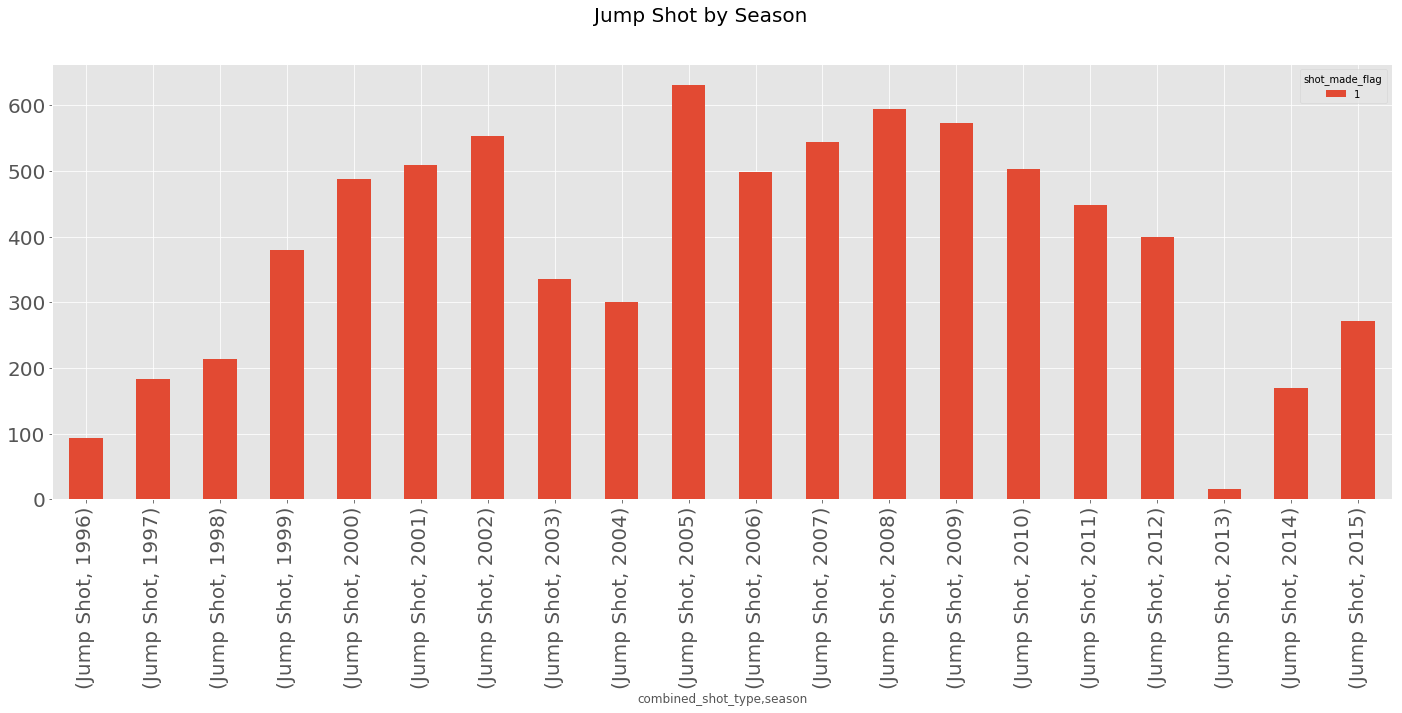

In [54]:
js_season = pd.crosstab([ df3['combined_shot_type'],df3['season'] ], 
                   df3.shot_made_flag.astype(int))
js_season.plot(kind="bar", 
                 figsize=(24,8),
                 stacked=False)

plt.suptitle('Jump Shot by Season', fontsize=20)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)


(array([    0.,   200.,   400.,   600.,   800.,  1000.]),
 <a list of 6 Text yticklabel objects>)

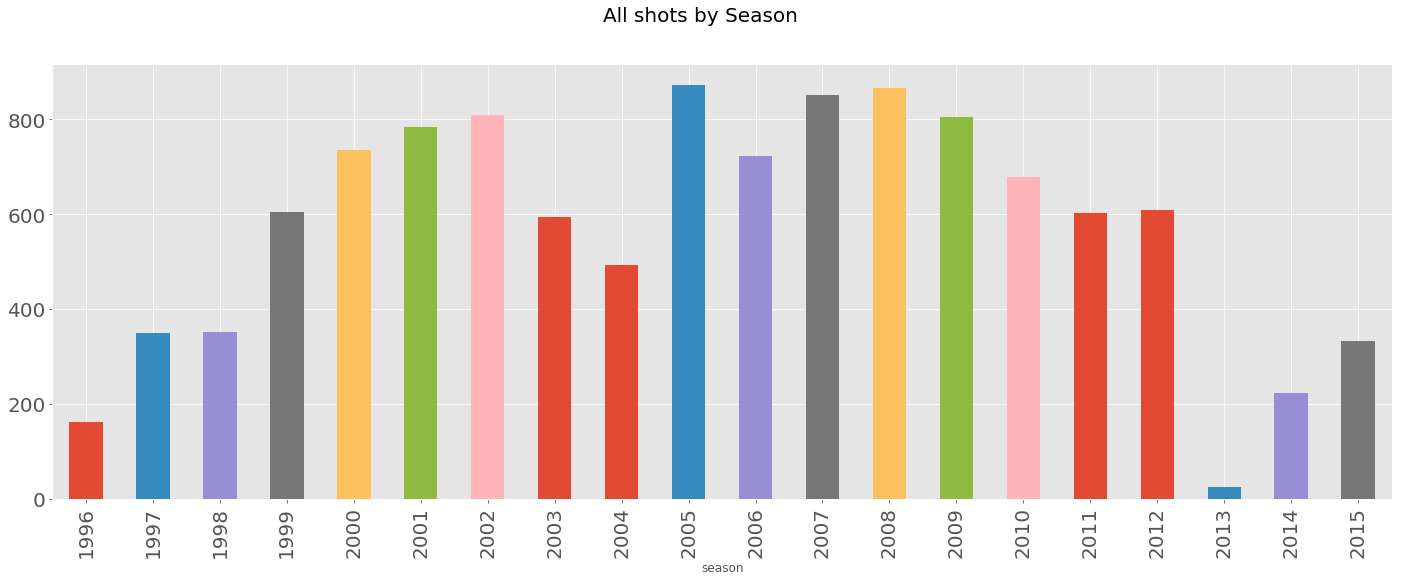

In [55]:
allshots_season = df2['shot_made_flag'].groupby(df2['season']).sum()
allshots_season.plot(kind="bar", 
                 figsize=(24,8),
                 stacked=False)

plt.suptitle('All shots by Season', fontsize=20)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)

In [67]:
# Feature selection
df_select = df2[['shot_distance','minutes_remaining','combined_shot_type','season','shot_type','shot_zone_area','playoffs','shot_made_flag']]
df_sdummy1 = pd.get_dummies(df_select)


In [69]:
#Features with a training-set variance lower than this threshold will be removed.
selector = VarianceThreshold(threshold=0.90)
selector.fit_transform(df_sdummy1)


array([[   15.,    10.,  2000.],
       [   16.,     7.,  2000.],
       [   22.,     6.,  2000.],
       ..., 
       [   21.,     3.,  1999.],
       [   26.,     2.,  1999.],
       [    7.,     0.,  1999.]])

In [71]:
# Features that meet the requirement of variance of more than 0.90
# To explain the relationship between shot types (variables) and shot made (target), Dummy variables were created.
# Heat map above confirms what has been mentioned above.
# shot_made_flag is moderately positive correlated to 2 points Dunk and Layup at a center shot_zone 
# while negatively correlated to jump shot. Field goal and combined shots_type are highly correlated to shot distance
# Next step is remove Layup and 2 PT field goals as both are highly correlated to Jump Start and 3PT respectively to 
# avoid multicollinearity


threshold = 0.90
vt = VarianceThreshold().fit(df_sdummy1)

# Find feature names
feat_select = df_sdummy1.columns[vt.variances_ > threshold * (1-threshold)]
feat_select

Index(['shot_distance', 'minutes_remaining', 'season', 'playoffs',
       'shot_made_flag', 'combined_shot_type_Jump Shot',
       'combined_shot_type_Layup', 'shot_type_2PT Field Goal',
       'shot_type_3PT Field Goal', 'shot_zone_area_Center(C)',
       'shot_zone_area_Left Side Center(LC)', 'shot_zone_area_Left Side(L)',
       'shot_zone_area_Right Side Center(RC)', 'shot_zone_area_Right Side(R)'],
      dtype='object')

In [72]:
# Summary:
# Over the career, Kobe has performed 19,710 Jump Shot which is 76.7% of the all his shot success. 
# However, the completion rate of the jump shot is only $39.2%. 
# Dunk, despite being the least shot made, has the highest shot success rate at 92.8%. 
# This may not be surprise given that dunking demands extra burst yet yield the same number of points as an easy layup. (https://www.wsj.com/articles/in-the-nba-dunking-isnt-for-everyone-1423762919)
# As indicated in the following cross-tabulation, Kobe is 4 times more likely to perform Layup shots than dunking 
# (1,056 vs, 4,532). He also has much better shot success with Layup shots, indicated by completion rate of 56.5%.
# The seasonality trend of jump shots is correlated to the seasonality of shots made.  
# The peak of his career was in 2005-2006 season where he has had the most jump shots. 
# However in the 2013-2014 season, there is a sharp decline of total number of shots. 
# This could possibly be because of an injury which caused him to be benched. 
# The trend never picks up and returns to his glory days when he played after the injury which may not be 
# all that surprised as with his retirement in 2016.

